In [132]:
import pandas as pd
import numpy as np
import os
import datetime

import set_config
import BATCHACTIVE
import QlikSense_OEE
import ORDER
import CNTR

# my modules|
from common_functions import create_df_from_file
from common_functions import create_shift_category

# call set_config
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']

# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# %matplotlib inline 

This produces a final dataframe with the following columns

| # | Column | Dtype | Description |  
|---| ------ | ----- | ----------- |  
| 0 |Name|object| 
| 1 |counter|int64|counter value from CNTR files|   
| 2 |IP_TREND_QLEVEL|object||  
| 3 |IP_TREND_QSTATUS|object||  
| 4 |Machine|object||  
| 5 |Type|object||  
| 6 |counter_diff|float64|difference between counter files of same name| 
| 7 |time_diff|float64|difference in time between counter files of same name| 
| 8 |In_Changeover|float64|1 if during changeover period (Florian formula), NaN if outside period| 
| 9 |Assembly_Order_No|object| 36630901_ORDERNUMBER file values| 
| 10|PAL_Order_No|object|36650901_ORDERNUMBER file values|  
| 11|BATCH_ID|object|36630901_BATCHID values|  
| 12|BATCH_SIZE|float64|36630901_MATNO values, believe is the number of pens per batch| 
| 13|Shift|category|EARLY, LATE, NIGHT, 06:00 - 14:00, 14:00-22:00, 22:00-06:00|

# CHANGEOVER

In [74]:
# call changeover - calculated from the BATCHACTIVE files
df_changeover = BATCHACTIVE.changeover()

# ORDER

In [4]:
# get the batch info 
df_order = ORDER.ORDER_files()

# COUNTER

In [5]:
df_CNTR = CNTR.CNTR_Files()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Merge Dataframes

## Create changeover category

In [6]:
df_CNTR.set_index('IP_TREND_TIME', inplace=True)

In [7]:
df_CNTR.rename(columns={'IP_TREND_VALUE':'counter'}, inplace=True)

In [8]:
# create a category of In_Changeover if times are between changeover start and end
for i, times in df_changeover.iterrows():
    df_CNTR.loc[(df_CNTR.index > times[0]) & (df_CNTR.index < times[1]), 'In_Changeover'] = 1

## Create Order Number column

Find rows for 36630901 order number changes and merge with df_CNTR

In [9]:
df_order.set_index('IP_TREND_TIME', inplace=True)

In [10]:
assembly_orders = df_order[df_order['36630901_ORDERNUMBER'].isna()==False]
pal_orders = df_order[df_order['36650901_ORDERNUMBER'].isna()==False]
# pd.DataFrame({'start':df_orders2.iloc[::2].values, 'end':df_orders2.iloc[1::2].values, 'time_diff_mins':df_orders2.time_diff_mins.iloc[1::2].values})
df_order2 = pd.merge_asof(df_CNTR.sort_index(), df_order.sort_index()[['36630901_ORDERNUMBER','36650901_ORDERNUMBER','BATCH_ID','BATCH_SIZE']].sort_index(), left_index=True, right_index=True, direction='forward', allow_exact_matches=True)
df_order2.rename(columns={'36630901_ORDERNUMBER':'Assembly_Order_No',
                          '36650901_ORDERNUMBER':'PAL_Order_No'}, inplace=True)


## Create Shift Category

In [15]:
# call create_shift_category with dataframe and which column you want to use
df_order2 = create_shift_category(df_order2)

In [16]:
filename = 'Batch_Order_Info.csv'
df_order2.to_csv(os.path.join(dir_sanofi_share, folder, filename))


In [48]:
df_order2.select_dtypes(include='number').columns.to_list()
# df_order2.set_index('IP_TREND_TIME', inplace=True)

['counter', 'counter_diff', 'time_diff', 'In_Changeover', 'BATCH_SIZE']

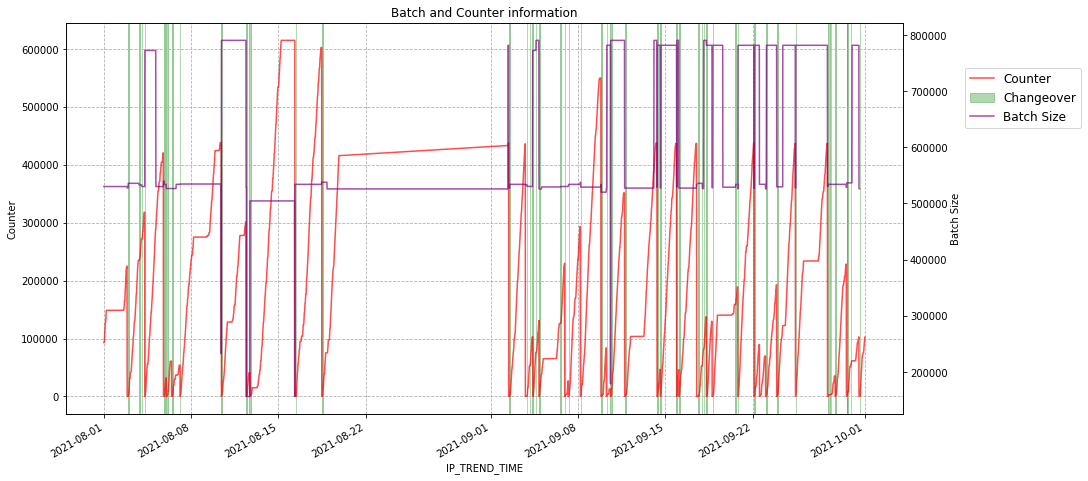

In [142]:

# cols = df_order2.select_dtypes(include='number').columns.to_list()
cols = ['counter','BATCH_SIZE']

fig, ax = plt.subplots(1, 1, figsize=(15, 8))

colors = ("red", "purple", "blue", "green", "orange")
i=0


#     group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label='Actual speed', ax=axs[i], alpha=0.7)
ax = df_order2.counter[df_order2.Name == '36630901_CNTR_GOOD'].plot(color='red', label='Counter', alpha=0.7)
# plt.yscale('log')

ax2 = df_order2['BATCH_SIZE'][df_order2.Name == '36630901_CNTR_GOOD'].plot(secondary_y=True, color='purple', label='Batch Size', alpha=0.7)


ax.grid(True,which="both", linestyle='--')
ax.set_title('Batch and Counter information')
i=0

for c, row in df_changeover.iterrows():
    ax.axvspan(row[0], row[1], color='green', alpha=0.3, label =  "_"*i + "Changeover")
    i+=1


# ax.legend(loc='lower right', bbox_to_anchor=(1.20, 0.9), fancybox=True)
# ax2.legend(loc='upper right', bbox_to_anchor=(1.20, 0.1), fancybox=True)
ax.right_ax.set_ylabel('Batch Size')
ax.set_ylabel('Counter')

# improve_legend(axs[i])

# this is how to add the two legends together
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.22, 0.9), fancybox=True)




i+=1

In [137]:
green_patch